<a href="https://colab.research.google.com/github/TanujBhatia1/Covid-19-Dashboard/blob/main/GerToEngMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [2]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [3]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [4]:
data = read_text("/content/rus.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [5]:
deu_eng = deu_eng[:50000,:]

In [6]:
deu_eng = np.delete(deu_eng, 2, 1)
deu_eng

array([['Go.', 'Марш!'],
       ['Go.', 'Иди.'],
       ['Go.', 'Идите.'],
       ...,
       ['The room was cold.', 'Комната была холодной.'],
       ['The room was dark.', 'В комнате было темно.'],
       ['The room was warm.', 'В комнате было тепло.']], dtype='<U100')

In [7]:
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [8]:
deu_eng

array([['Go', 'Марш'],
       ['Go', 'Иди'],
       ['Go', 'Идите'],
       ...,
       ['The room was cold', 'Комната была холодной'],
       ['The room was dark', 'В комнате было темно'],
       ['The room was warm', 'В комнате было тепло']], dtype='<U100')

In [9]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()

    deu_eng[i,1] = deu_eng[i,1].lower()

In [10]:
deu_eng

array([['go', 'марш'],
       ['go', 'иди'],
       ['go', 'идите'],
       ...,
       ['the room was cold', 'комната была холодной'],
       ['the room was dark', 'в комнате было темно'],
       ['the room was warm', 'в комнате было тепло']], dtype='<U100')

In [11]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [12]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

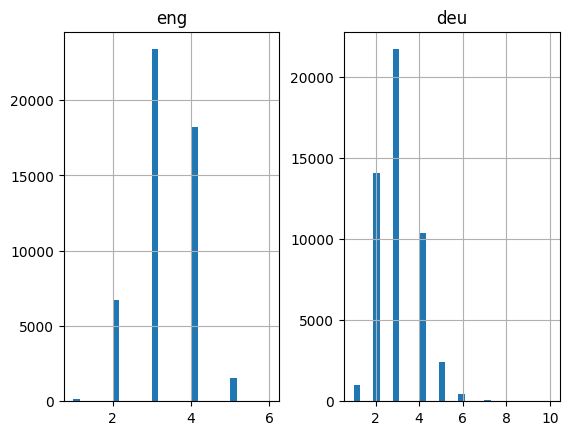

In [13]:
length_df.hist(bins = 30)
plt.show()

In [14]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [15]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 5048


In [16]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 13766


In [17]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [18]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [19]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [20]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [21]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [23]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [24]:
filename = 'model.h1.2_Dec_23'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
          epochs=30, batch_size=512,
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 4.0210
Epoch 1: val_loss improved from inf to 2.89846, saving model to model.h1.2_Dec_23
63/63 [==============================] - 278s 4s/step - loss: 4.0210 - val_loss: 2.8985
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 2.6488
Epoch 2: val_loss improved from 2.89846 to 2.51856, saving model to model.h1.2_Dec_23
63/63 [==============================] - 266s 4s/step - loss: 2.6488 - val_loss: 2.5186
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 2.4710
Epoch 3: val_loss improved from 2.51856 to 2.45586, saving model to model.h1.2_Dec_23
63/63 [==============================] - 287s 5s/step - loss: 2.4710 - val_loss: 2.4559
Epoch 4/30
63/63 [==============================] - ETA: 0s - loss: 2.4199
Epoch 4: val_loss improved from 2.45586 to 2.40176, saving model to model.h1.2_Dec_23
63/63 [==============================] - 268s 4s/step - loss: 2.4199 - val_loss: 2.4018
Epoch 5/

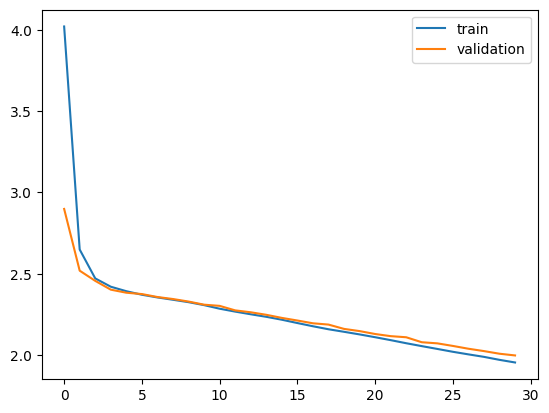

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [26]:
model = load_model('model.h1.2_Dec_23')
preds = np.argmax(model.predict(testX.reshape((testX.shape[0],testX.shape[1]))),axis=-1)

313/313 [==============================] - 40s 116ms/step


In [27]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [28]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)

        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)

    preds_text.append(' '.join(temp))

In [29]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [30]:
pd.set_option('display.max_colwidth', 200)

In [31]:
pred_df.head(15)

,actual,predicted
0,i was in the gym,i was a
1,forget it,are
2,im a pisces,im a
3,i ate a pear,i was a
4,hes from georgia,he was a
5,why did you hide,did you
6,i need to see you,i to you
7,arent you sleepy,you
8,i was an idiot,i was a
9,do as youre told,who you


In [32]:
pred_df.sample(15)

,actual,predicted
8592,we missed you,we you
1960,i was hungry,i was a
8716,its very new,he was a
7101,lets calm down,lets the is
6719,thats for you,tom
2101,i found tom,i want tom
1659,tom has grown up,tom is
4106,youre a dreamer,youre you
471,tom is lonely,tom is
2209,youre strong,youre you


In [44]:
preds_text=np.array(preds_text)
preds_text


array(['i was a     ', 'are       ', 'im a      ', ..., 'he was a     ',
       'did you      ', 'i want you     '], dtype='<U19')

In [45]:
test[:,0]

array(['i was in the gym', 'forget it', 'im a pisces', ...,
       'he is my uncle', 'when will you go', 'i look like tom'],
      dtype='<U100')

In [48]:
from nltk.translate.bleu_score import sentence_bleu


# Calculate BLEU score for unigrams (individual words)
bleu_score = sentence_bleu([test[:,0]],preds_text, weights=(1, 0, 0, 0))

# Print the BLEU score
print(f"BLEU Score: {bleu_score}")


BLEU Score: 0
